In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import shap, datetime, warnings
warnings.filterwarnings('ignore')

c:\Users\Steven\Desktop\school github repos\svo-directed-practicum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))

In [3]:
sentiment_cols = [i for i in df.columns if any(x in i for x in ['Article Count', 'Tone', 'llm'])] + [i for i in df.columns if i.startswith('c') or i.startswith('v')]
time_cols = ['hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10','month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8','month_of_year_9','day_of_week_0','day_of_week_1','day_of_week_2','day_of_week_3','day_of_week_4']
self_finance_vars = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and all(x not in i for x in ['BNO','JETS','IYT','ITA'])]
oil_vars          = [i for i in df.columns if 'lag' in i and 'BNO' in i]
etf_finance_vars  = [i for i in df.columns if 'lag' in i and i not in sentiment_cols and any(x in i for x in ['JETS','IYT','ITA'])]
finance_vars = self_finance_vars + oil_vars + etf_finance_vars

In [4]:
# Define the different sets of features to try
feature_sets = {
    'all': sentiment_cols + finance_vars + time_cols 
}

In [5]:
y_cols = ['Volume']
y = df[y_cols]
# Train/test splitting
split_val  = round(0.8 * len(y))
split_test = round(0.9 * len(y))

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

predictions = df[['date','ticker','Volume']+time_cols]
predictions = predictions.iloc[split_val:, :]
predictions.rename(columns={'Volume': 'Actual'}, inplace=True)

In [6]:
# Add the tuned and retrained models as well
model = pickle.load(open(f'../../output/models/LightGBM/lightgbm_all_tuned_retrained.pkl', 'rb'))

x_cols = feature_sets['all']
x = df[x_cols]
x_train = x[:split_val]
x_val   = x[split_val:split_test]
x_test  = x[split_test:]

# Normalize the features to [0,1]
sc2 = MinMaxScaler(feature_range=(0, 1))

x_train = sc2.fit_transform(x_train)
x_val   = sc2.transform(x_val)
x_test  = sc2.transform(x_test)
x_eval = np.concatenate((x_val, x_test), axis=0)

In [7]:
# sample 1000 rows from x_eval
np.random.seed(42)
x_sample = x_eval[np.random.choice(x_eval.shape[0], size=1000, replace=False), :]

In [11]:
# shap values
explainer = shap.TreeExplainer(model, x_sample, feature_names=x.columns)
shap_values = explainer(x_sample, check_additivity=False)
pickle.dump(shap_values, open('../../output/models/LightGBM/lightgbm_shap_values.pkl', 'wb'))

100%|===================| 999/1000 [14:19<00:00]        

In [8]:
shap_values = pickle.load(open('../../output/models/LightGBM/lightgbm_shap_values.pkl', 'rb'))

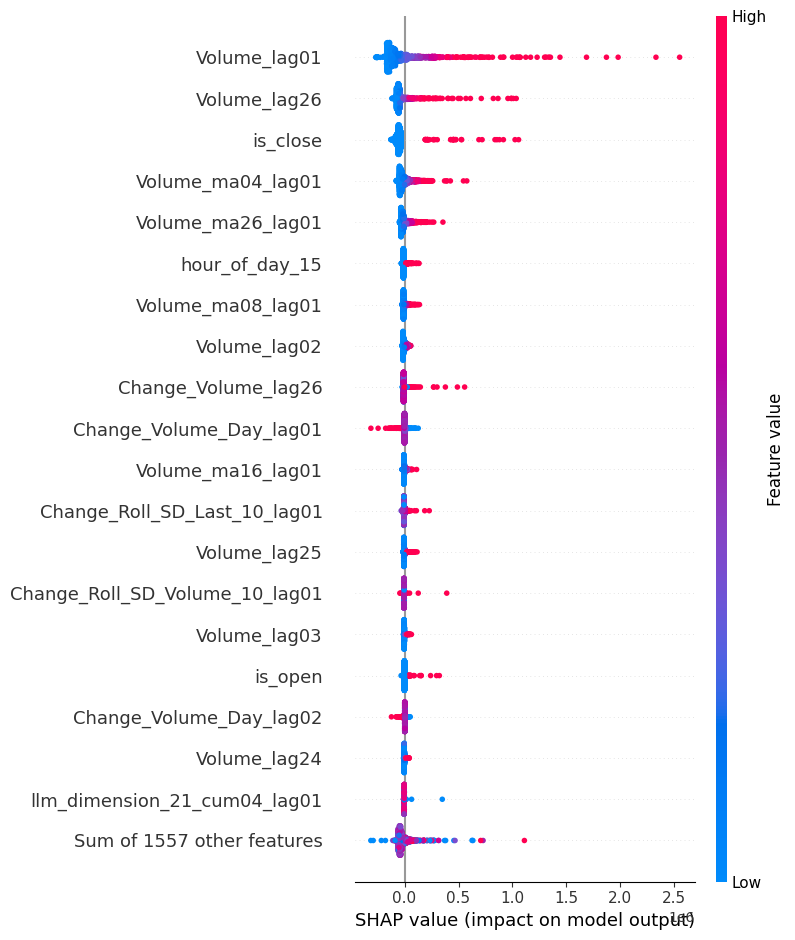

In [12]:
fig = plt.figure(figsize=(10, 15))
fig.add_axes(shap.plots.beeswarm(shap_values, max_display=20, show=False))
fig.tight_layout()
fig.savefig('../../output/shap_beeswarm_all.pdf')

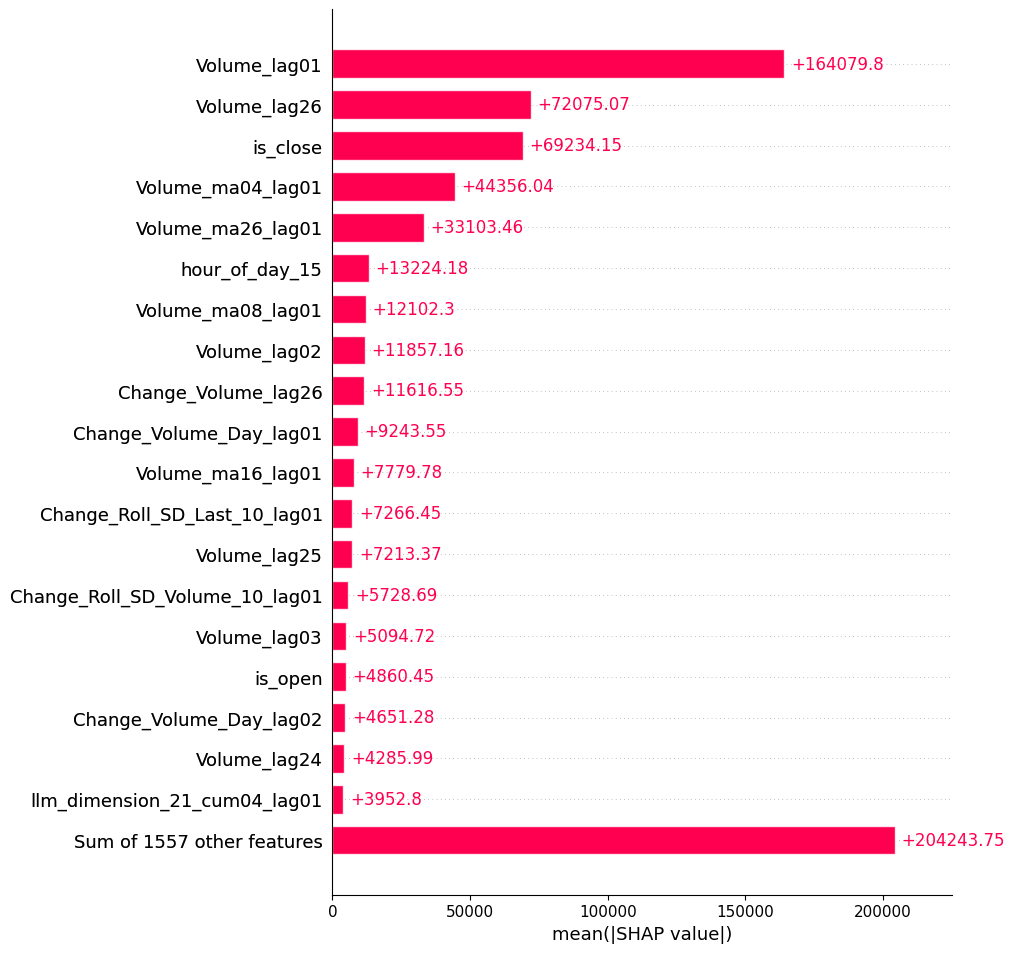

In [47]:
shap.plots.bar(shap_values.abs.mean(0), max_display=20)

In [ ]:
# Identify the unique sentiment variable names
sentiment_vars = [i.replace('_lag01','').replace('_cum04','').replace('_cum16','').replace('_cum48','').replace('_cum96','') for i in sentiment_cols]
sentiment_vars = list(set(sentiment_vars))

df_shap = pd.DataFrame(shap_values.values, columns=x.columns)

for i in sentiment_vars:
    df_shap[i] = np.abs(df_shap[[j for j in df_shap.columns if i in j]].sum(axis=1))
df_shap
df_shap = df_shap[sentiment_vars]
df_agg = df_shap.mean(axis=0).to_frame(name='Mean Absolute Shapley Value').reset_index()

df_agg

,index,Mean Absolute Shapley Value
1,c18.223; WORDCOUNT; ECON_DEBT,306.908691
2,c18.279; WORDCOUNT; ECON_MOU,0.009707
3,c18.63; WORDCOUNT; ECON_INTEREST_RATES,142.189625
4,c4.16; WORDCOUNT; FINANCE,470.809664
5,v20.4; SCOREDVALUE; Level2Negative (Scored Value),134.904111
...,...,...
145,c18.341; WORDCOUNT; ECON_WORLDCURRENCIES,363.001946
146,v42.7; SCOREDVALUE; care_sent,982.171971
147,c18.325; WORDCOUNT; ECON_ELECTRICALDEMAND,1.573410
148,c3.2; WORDCOUNT; POSITIVE,160.950292


In [22]:
sentiment_vars = [i.replace('_lag01','').replace('_cum04','').replace('_cum16','').replace('_cum48','').replace('_cum96','') for i in sentiment_cols]
sentiment_vars = list(set(sentiment_vars))

df_shap = pd.DataFrame(shap_values.values, columns=x.columns)

for i in sentiment_vars:
    df_shap[i] = df_shap[[j for j in df_shap.columns if i in j]].sum(axis=1)
df_shap
df_shap = df_shap[sentiment_vars]
df_agg = df_shap.mean(axis=0).to_frame(name='Mean Shapley Value').reset_index()

df_agg

,index,Mean Shapley Value
0,llm_dimension_10,15.778348
1,c18.223; WORDCOUNT; ECON_DEBT,-1.173886
2,c18.279; WORDCOUNT; ECON_MOU,0.009707
3,c18.63; WORDCOUNT; ECON_INTEREST_RATES,22.916059
4,c4.16; WORDCOUNT; FINANCE,248.582741
...,...,...
145,c18.341; WORDCOUNT; ECON_WORLDCURRENCIES,-208.493868
146,v42.7; SCOREDVALUE; care_sent,-86.885198
147,c18.325; WORDCOUNT; ECON_ELECTRICALDEMAND,0.332038
148,c3.2; WORDCOUNT; POSITIVE,52.279792


In [24]:

df_shap = pd.DataFrame(shap_values.values, columns=x.columns)
df_shap

,Article Count_cum04_lag01,Article Count_cum16_lag01,Article Count_cum48_lag01,Article Count_cum96_lag01,Article Count_lag01,Tone_cum04_lag01,Tone_cum16_lag01,Tone_cum48_lag01,Tone_cum96_lag01,Tone_lag01,...,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4
0,0.000000,-1.704518,-8.203226,-1.202577,0.000000,32.786896,-218.234839,-47.104310,3.037257,2.221279,...,-9.010096,-0.024757,-2.426388,-1.229328,-45.102339,2.629025,-18.154254,-218.440870,15.843326,-258.210665
1,-0.210991,-0.125334,-4.951709,-0.265213,0.007473,-40.079248,13.959463,288.209576,122.355263,-62.641808,...,-0.933641,-0.193577,-12.849805,-1.181543,-31.280686,2.311965,-24.154152,-263.297342,-23.196118,-166.685541
2,-0.133822,-0.286289,-10.405489,2.776889,0.023654,15.596085,-28.515179,18.115310,-36.177933,-16.119529,...,-1.104990,-0.472531,-0.004096,-1.613704,-31.228303,3.049784,30.879480,-178.620089,0.226272,-112.718042
3,-0.141099,-0.506243,-9.667623,0.439203,0.153239,18.132645,-14.483892,0.024330,-32.929004,-13.195056,...,-1.278508,-0.945329,-0.025779,-2.427161,319.896170,2.704844,26.387980,-164.205884,0.333416,-105.135368
4,0.000000,-0.094095,-1.561719,-0.454763,0.000000,-1.627310,32.412253,287.619341,2.025620,-115.740047,...,-0.475411,-13.194949,-0.020500,-0.722357,-71.143540,1.936630,6.442061,-373.903329,0.887897,-201.794966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.163081,-0.206283,-4.441724,1.304556,0.007473,16.588615,-20.475353,-38.098910,-49.491175,-14.355860,...,-2.256948,-5.238333,-0.049966,-1.693157,-37.366831,13.477671,-9.435885,-436.806940,1.729260,1916.143859
996,-0.175854,-0.538889,-9.704125,0.788107,0.040454,55.974495,-49.318129,-15.557609,-39.003608,-12.481901,...,-7.212536,-0.392646,-0.028840,-1.552473,-31.868962,9.904286,-10.320824,-371.946382,-0.127420,1807.498964
997,-0.107731,-0.098653,-4.681997,1.042579,0.090219,12.364090,-26.767379,13.434850,-33.352701,-15.725494,...,-1.232757,-0.575077,-0.071865,5.400027,-30.507305,-13.349700,-13.431084,-163.828124,0.391188,-101.354768
998,-0.008128,-0.419118,-4.835399,-2.030125,-0.743889,-1.387576,-80.056619,6.425593,14.272373,-25.665225,...,-1.403861,-0.391168,-0.100974,-2.698802,-31.126963,-15.351079,-9.421046,-197.623139,0.332170,-119.529968


In [ ]:
'Tone_lag01': 'Tone',
'Article Count_lag01': 'Article Count',
'v11.1; SCOREDVALUE; Polarity (Scored Value)_lag01': 'Polarity',
'v10.2; SCOREDVALUE; Negative (Scored Value)_lag01': 'Negative',
'v10.1; SCOREDVALUE; Positive (Scored Value)_lag01': 'Positive',
'c18.314; WORDCOUNT; ECON_OILPRICE_lag01': 'Oil Price',
'c18.60; WORDCOUNT; ECON_EARNINGSREPORT_lag01': 'Earnings Report',
'v42.7; SCOREDVALUE; care_sent_lag01': 'Care (+) / Harm (-)',
'v42.11; SCOREDVALUE; sanctity_sent_lag01': 'Sanctity (+) / Degradation (-)',

In [23]:
df_agg[df_agg['index'].isin([
    'Tone',
    'Article Count',
    'v11.1; SCOREDVALUE; Polarity (Scored Value)',
    'v10.2; SCOREDVALUE; Negative (Scored Value)',
    'v10.1; SCOREDVALUE; Positive (Scored Value)',
    'c18.314; WORDCOUNT; ECON_OILPRICE',
    'c18.60; WORDCOUNT; ECON_EARNINGSREPORT',
    'v42.7; SCOREDVALUE; care_sent',
    'v42.11; SCOREDVALUE; sanctity_sent',
])]

,index,Mean Shapley Value
26,c18.314; WORDCOUNT; ECON_OILPRICE,95.830558
37,c18.60; WORDCOUNT; ECON_EARNINGSREPORT,1.652028
57,v10.2; SCOREDVALUE; Negative (Scored Value),9.424247
71,Article Count,-12.904676
90,v11.1; SCOREDVALUE; Polarity (Scored Value),93.029706
92,Tone,-40.365800
133,v42.11; SCOREDVALUE; sanctity_sent,-67.148344
138,v10.1; SCOREDVALUE; Positive (Scored Value),-14.404056
146,v42.7; SCOREDVALUE; care_sent,-86.885198


In [19]:
# limit to top variables
df_plot = df_agg.filter(items=[
    'Tone',
    'Article Count',
    'v11.1; SCOREDVALUE; Polarity (Scored Value)',
    'v10.2; SCOREDVALUE; Negative (Scored Value)',
    'v10.1; SCOREDVALUE; Positive (Scored Value)',
    'c18.314; WORDCOUNT; ECON_OILPRICE',
    'c18.60; WORDCOUNT; ECON_EARNINGSREPORT',
    'v42.7; SCOREDVALUE; care_sent',
    'v42.11; SCOREDVALUE; sanctity_sent',
])

plt.figure(figsize=(10, 5))

sns.barplot(
    data=df_plot, 
    x='Mean Absolute Shapley Value', 
    y='index')

plt.ylabel('')
plt.tight_layout()
#plt.savefig('../../output/shap_sentiment_contributions.pdf')

ValueError: Could not interpret value `Mean Absolute Shapley Value` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

In [ ]:
# limit to top variables
df_plot = df_agg.nlargest(10, 'Mean Absolute Shapley Value')

plt.figure(figsize=(10, 5))

sns.barplot(
    data=df_plot, 
    x='Mean Absolute Shapley Value', 
    y='index')

plt.ylabel('')
plt.tight_layout()
plt.savefig('../../output/shap_sentiment_contributions.pdf')

In [22]:
df_agg['index'].value_counts()

index
v20.16; SCOREDVALUE; Level8Negative (Scored Value)    1
c18.317; WORDCOUNT; ECON_HEATINGOIL                   1
c6.4; WORDCOUNT; Negative                             1
llm_dimension_18                                      1
c18.280; WORDCOUNT; ECON_CUTOUTLOOK                   1
                                                     ..
llm_dimension_17                                      1
c18.50; WORDCOUNT; SHORTAGE                           1
c18.258; WORDCOUNT; ECON_BOYCOTT                      1
c18.21; WORDCOUNT; LEGISLATION                        1
llm_dimension_08                                      1
Name: count, Length: 150, dtype: int64

In [21]:
df_agg[df_agg['index'].isin(['Tone','Positive Score','Negative Score',
                             'Polarity','Activity Reference Density',
                             'Self/Group Reference Density','Word Count']
                             )]

,index,Mean Absolute Shapley Value
99,Tone,175.290099


In [49]:
shap_values[:, 'llm_dimension_21_cum04_lag01']

.values =
array([ -2993.39722962,  -4714.63114841,  -3277.08554147,  -3198.59262978,
        -9607.64636004,  -3526.94914651,  -3705.17899841,  -3467.48926763,
        -5109.57042826,  -3074.12991683,  -3435.93364226,  -3360.58006734,
        -3380.49384786,  -3367.18533566,  -3402.21734247,  -3808.60000049,
        -2559.23481681,  -3812.57973385,  -3252.93976266,  -3643.20971162,
        -7658.04836028,  -3203.91608927,  -3415.27143851,  -3462.92468835,
        -3115.91056078,  -3256.1526888 ,  -3481.18724539,  -3362.42397517,
        -3520.48161387,  -3318.94954363,  -3432.30233708,  -3625.61425043,
        -3342.0858133 ,  -3654.27219632,  -3822.2092219 ,  -4220.68247768,
        -3520.58808001,   1589.15030893,  -3410.58728856,  -3394.5756447 ,
        -3546.29626648,  -3587.814758  ,  -3525.95655579,  -3353.32283437,
        -4568.98006039,  -3202.06216359,  -3623.4972938 ,  -3425.81378741,
        -3223.76779998,  -6083.59984252,  -3536.52083745,  -3312.37401208,
        -3867.0

(array([998.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ -9607.64636004,  26317.32103746,  62242.28843496,  98167.25583246,
        134092.22322996, 170017.19062746, 205942.15802496, 241867.12542246,
        277792.09281996, 313717.06021746, 349642.02761496]),
 <BarContainer object of 10 artists>)

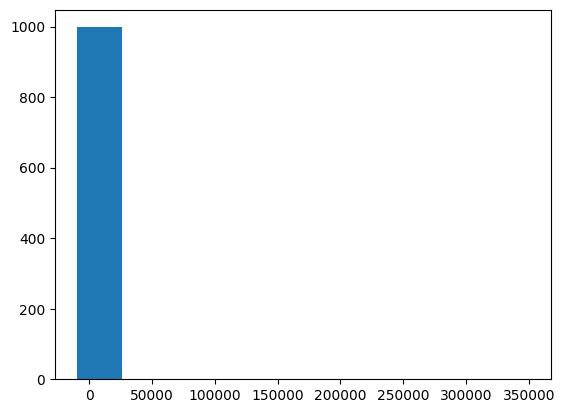

In [43]:
plt.hist(
        shap_values[:, 'llm_dimension_21_cum04_lag01'].values,
    )

In [23]:
# Question: how much do the sentiment variables contribute to the model?
df_shap = pd.DataFrame(shap_values.values, columns=x.columns)
df_shap = df_shap[sentiment_cols]
df_shap_sum_sentiment = df_shap.sum(axis=1).to_frame(name='shap_sum_sentiment')
df_shap_sum_sentiment['symlog'] = df_shap_sum_sentiment.apply(lambda x: np.sign(x) * np.log10(np.abs(x)))
df_shap_sum_sentiment

,shap_sum_sentiment,symlog
0,3359.832602,3.526318
1,-18731.272095,-4.272567
2,-7529.607311,-3.876772
3,-7337.103714,-3.865525
4,42865.424247,4.632107
...,...,...
995,-7658.651168,-3.884152
996,-6933.792339,-3.840971
997,-7941.476373,-3.899901
998,3759.292835,3.575106


<Axes: xlabel='shap_sum_sentiment', ylabel='Percent'>

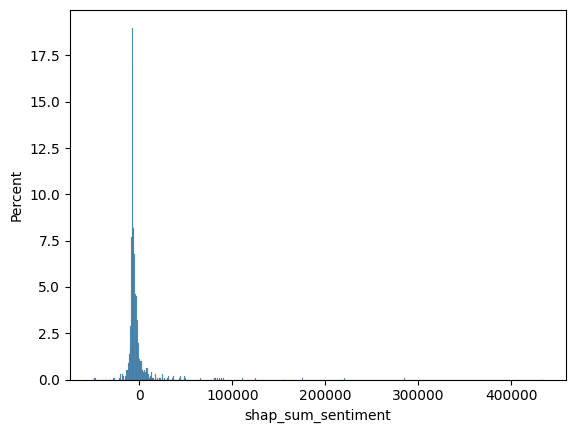

In [31]:
sns.histplot(df_shap_sum_sentiment['shap_sum_sentiment'], stat='percent')

<Axes: xlabel='symlog', ylabel='Percent'>

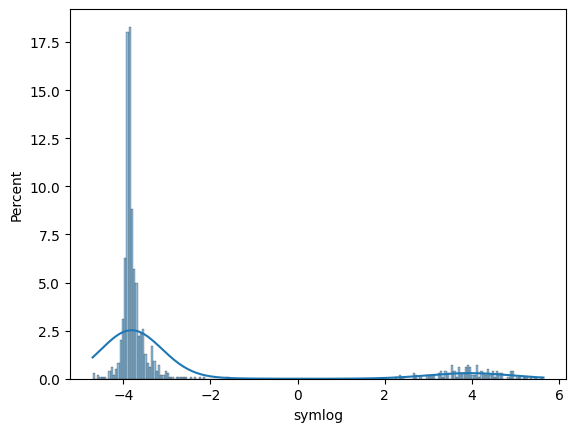

In [25]:
sns.histplot(df_shap_sum_sentiment['symlog'], bins=200, kde=True, stat='percent')